# Studying Some Properties of Wikipedia's Network

## 1. Intro

The idea of the project is to explore Wikipedia's network to see if we can see how France and Germany are related to energy (i.e. difference in the renewable energy mix for example ?) and if there is a bias in the perception of this relation to energy depending on the country.
To do so we construct a (directed) network by doing a *pseudo-Breadth First Search (BFS)* with a certain empirical depth where the edges are the links between pages.
By *pseudo-BFS* we mean that instead of not taking into account the links netween nodes already seen, we do link those so that we do not obtain a tree but rather a sample of the true Wikipedia's network.

#### Imports

In [2]:
import requests # That's to get the links from a wikipedia page
import os, time, glob, pickle
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import graph_tool.all as gt # Graphtool can be used to plot the graphs nicely (better than networkx) using python
import networkx as nx # Networkx is more convenient to analyze graphs

## 2. Choosing, Preparing and Cleaning the Network

We build the network using a snippet of code taken from  https://gitlab.com/snippets/1920139 to retrieve the links from a Wikipedia page given it's title.
However, as we do not want to get ALL the links, we take only those pertaining to some category (and it's subcategories) of interest. Let's focus on "Energy" !

**The code below my take some time to run in its original form. 
The reader is nonetheless welcome to modify some parameters (e.g. max allowed number of nodes)
to get a feel of how the network was built.**

### 2.1 Create the filters 

The goal here is to get all the subcategories of "Energy" so as to filter the links between wikipedia pages.

$\rightarrow$ See the file *Cpx-generate-filters.ipynb*

### 2.2 Get all child links and categoriesn from a page

In [ ]:
def all_links(title, language, plcontinue=None):
    url = "https://{lang}.wikipedia.org/w/api.php".format(lang=language)
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "links",
        "pllimit": "max",
        "plnamespace": 0,
    }
    if plcontinue:
        params["plcontinue"] = plcontinue

    data = requests.get(url, params=params)
    data = data.json()
    plcontinue = data.get("continue", {}).get("plcontinue", None)
    for items in data["query"]["pages"].values():
        for link in items.get("links", []):
            yield link["title"]

    if plcontinue is not None:
        yield from all_links(title, language, plcontinue=plcontinue)

def all_categories(title, language, clcontinue=None):
    url = "https://{lang}.wikipedia.org/w/api.php".format(lang=language)
    params = {
        "action": "query",
        "format": "json",
        "prop": "categories",
        "titles": title,
        "cllimit": "max",
 #       "plnamespace": 0,
    }
    if clcontinue:
        params["clcontinue"] = clcontinue

    data = requests.get(url, params=params)
    data = data.json()
    clcontinue = data.get("continue", {}).get("clcontinue", None)
    for items in data["query"]["pages"].values():
        for cat in items.get("categories", []):
            yield cat["title"]

    if clcontinue is not None:
        yield from all_categories(title, language, clcontinue=clcontinue)

Cleanup the lists, i.e. remove all entries that do not correspond to a proper title, namely :
* The entrie that start with a "." (usually these are language links)

This can be done without too much computing time as the lists are sorted.

In [ ]:
def clean_entries(rawlist):
    ''' This function takes a generator as input ! '''
    rawlist = np.array(list(rawlist))
    L = rawlist.size
    
    if L == 0:
        return rawlist
    else:
        lowcut = 0
        while (rawlist[lowcut][0] == "."):
            lowcut += 1
            if lowcut == L:
                return np.array([])
        
        isnonumber = False # Initialize to False to go in the loop
        while (not isnonumber):
            try :
                int(rawlist[lowcut][0])
                isnonumber = False
                lowcut += 1
                if lowcut == L:
                    return np.array([])
            except ValueError:
                isnonumber = True
                
        return rawlist[lowcut:]

Let's check if the function works, and what it does :

In [ ]:
lfr = all_links("France", "fr")

In [ ]:
np.array(list(lfr))

In [ ]:
t1 = time.time()
lfr = clean_entries(np.array(list(lfr)))
t2 = time.time()
deltat = t2 - t1
for l in lfr:
    print(l)
print("Took {} seconds to clean entries !".format(deltat))

In [ ]:
len(lfr)

Note that as we incorporated filters, ***we do not need to clean the entries anymore***.

### 2.3 Creating the network(s)

Now let's create our network using the networkx library. The idea is as following :
* We want to explore Wikipedia's Network.
* As the network is obviously too big (two million nodes in english !), we explore the it using a BFS
starting from a given entry, e.g. "France" or "Germany". We define a certain depth the BFS should not
go beyond to restrain the exploration.
* To give more meaning to the obtained network, we **filter** the links we take from one page.
We do so by checking if the page the link refers to belongs to the category "Energy" or one of all it's
subcategories (up to a depth of 4, i.e. we take into account the subcategories, the subsubcategories, the subsubsubcategories and the subsubsubsubcategories of the category "Energy").
* We want to create such a network for three different languages $\rightarrow$ German (de), English (en) and 
French (fr).
* The network is by default directed (parent $\rightarrow$ children),
as it can be easily converted to an undirected one if need be.

#### 2.3.1 Load the filters

Note that all the filters are of "category 4" meaning that they contain all subcategories of the category "Energy"
up to a depth of 4.

In [ ]:
# Load the filters of interest
cwd = os.getcwd()
category_filter = {}
# French filter
language = "fr"
filename= "{}/energy_subcat-{}-L5404".format(cwd, language)
print(filename)
with open(filename, 'rb') as picklefile:
    category_filter[language] = pickle.load(picklefile)
# German filter
language = "de"
filename= "{}/energy_subcat-{}-L1187".format(cwd, language)
print(filename)
with open(filename, 'rb') as picklefile:
    category_filter[language] = pickle.load(picklefile)
# English filter
language = "en"
filename= "{}/energy_subcat-{}-L9391".format(cwd, language)
print(filename)
with open(filename, 'rb') as picklefile:
    category_filter[language] = pickle.load(picklefile)

In [ ]:
# Check our filters
print(category_filter)
# Check how many entries that is, for some language
len(category_filter["de"])

#### 2.3.2 Define the starting entries and their translations in different languages

In [ ]:
Starters = {} # The dictionary containin the initial entries and their translations

Starters["France"] = {"fr" : "France",
            "en" : "France",
            "de" : "Frankreich",
    }

Starters["Deutschland"] = {"fr" : "Allemagne",
          "en" : "Germany",
          "de" : "Deutschland"
    }

#### 2.3.3 Explore Wikipedia's network

First, define the function to explore the network :

In [ ]:
def explore_network(language, initial_entry, category_filter, restrictions_dic):
    ''' Inputs :
            - language -> [string]; either "en", "fr", or "de", language we browse wikipedia in,
            - initial_entry -> [string]; Wikipedia page we start the exploration from,
            - category_filter -> [generator]; the filter containing categories of interest
            - restrictions -> [dictionary]; restrictions to avoid browsing the whole network
        Outputs :
            - A networkx newtork object where the nodes are Wikipedia pages and the edges the links between them.
        '''
    
    # Strings used for interactive output
    outstr1 = r"*–> Took {} (total {}) seconds to process 500 more nodes (total {}) !"
    outstr2 = r"*–> Currently at node {}, layer {}, still {} to go !"
    
    # Recover the whole filter from the generator
    array_filter = np.array(sorted(category_filter))
    
    # Recover the restrictions
    maxdepth = restrictions_dic["max_depth"]
    maxnodes = restrictions_dic["max_nodes"]
    maxdeg = restrictions_dic["max_deg"]
    
    # Initialize the "pseudo-BFS"
    u = initial_entry # node we start the exploration from
    queue = [u] # the queue of nodes to be processed
    n = 0 # order in which the nodes are added to the queue and thus the graph
    nprocessed = 0 # nb of processed nodes
    
    # Initialize the networkx network
    G = nx.DiGraph()
    G.add_node(u)
    G.nodes[u]["order"] = n
    G.nodes[u]["layer"] = 0
    
    # Run a "pseudo-BFS" for as many layers as needed
    t0 = time.time()
    t1 = time.time()
    while (queue != []):
        u = queue[0]
        u_neighbors = all_links(u, language) # note that this is a generator !
        # u_neighbors = clean_entries(u_neighbors) # We don't need to clean the list with the filter
        u_layer = G.nodes[u]["layer"]
        u_order = G.nodes[u]["order"]
        
        # A little message to wait before the graph finishes completing once we've seen enough nodes
        if (nprocessed == maxnodes) and (u_order % 100 == 0):           
                        print(r"|")
                        print(outstr2.format(u_order, u_layer, len(queue)))  
            
        # Iterate over the generator. Note that if it is empty then nothing happens and "queue" is poped -> good !
        for v in u_neighbors:
            # Check if the node is not a language link
            if v[0] != ".":
                # Check if the node has already been seen
                if v in G.nodes():
                    G.add_edge(u, v)                              
                # Stop adding nodes once we've seen enough                                                                    len(queue)))
                elif (nprocessed < maxnodes) and (u_layer < maxdepth): 
                    vpage_gen = all_categories(v, language)
                    vpage_categories = np.array(list(vpage_gen))                                                                                           
                    # Only consider neighbors that belong to some category of "Energy"
                    if (np.intersect1d(vpage_categories, array_filter).size != 0):
                        G.add_edge(u, v)
                        G.nodes[v]["order"] = n + 1
                        G.nodes[v]["layer"] = u_layer + 1
                        # This was added in the end, so not available in most of the networks
                        G.nodes[v]["categories"] = np.intersect1d(vpage_categories, array_filter)
                        queue.append(v)
                        n += 1
                        nprocessed += 1
                    else:
                        nprocessed += 1

                    if (nprocessed % 500 == 0) and (nprocessed > 0):           
                        t2 = time.time()
                        deltat = t2 - t1
                        print(r"|")
                        print(outstr1.format(deltat, (t2 - t0), nprocessed))
                        print(outstr2.format(u_order, u_layer, len(queue)))
                        t1 = time.time()
                              
        # Dequeue the node once all its neighbors have been seen
        queue.pop(0)
    
    t3 = time.time()
    deltat = t3 - t0
    print("Took {} seconds to build the whole network !".format(deltat))

    return G

Note that here, for time and memory reasons, we need to restrict our network exploration.
The restrictions are listed below :

In [ ]:
restrictions = {"max_depth" : 10, # How deep in the "BFS" we are allowed to go
                "max_nodes" : int(2e4), # Maximum of nodes EXPLORED (and not necessarily part of the network)
                "max_deg" : int(1e4)  # Maximum degree allowed for a node -> here a very big value to avoid cut-off
               }

Now we can explore the network for a specific base entry (= starting point),
for the different languages specified in the dictionary "Starters" :

In [ ]:
LangNetwork = {} # Dictionary to create data for a specific "base entry" and different languages

In [ ]:
# Define the base entry
base_entry = "France"

# Define a path to which the graph will be written
cwd = os.getcwd()
basepath = "{cwd}/network-{baseentry}-{language}_{maxdeg}-{maxnodes}-{maxlayer}.{ext}"

# For every language corresponding to this entry
for key, item in Starters[base_entry].items():
    # Explore the Network
    print()
    print("Processing \"{}\" network with base entry \"{}\"".format(key, base_entry))
    #LangNetwork[key] = explore_network(key, item, category_filter[key], restrictions)
    print(LangNetwork[key])
    # Save the network to different file formats
    print("Saving \"{}\" network ...".format(key))
    filename = basepath.format(cwd=cwd, baseentry=base_entry, language=key,
                               maxdeg=restrictions["max_deg"],
                               maxnodes=restrictions["max_nodes"],
                               maxlayer=restrictions["max_depth"], ext="graphml")
    nx.write_graphml(LangNetwork[key], filename)
    filename = basepath.format(cwd=cwd, baseentry=base_entry, language=key,
                               maxdeg=restrictions["max_deg"],
                               maxnodes=restrictions["max_nodes"],
                               maxlayer=restrictions["max_depth"], ext="gml")
    nx.write_gml(LangNetwork[key], filename)

In [ ]:
# Save the networks to open them in gephi
cwd = os.getcwd()
basepath = "{cwd}/network-{baseentry}-{language}_{maxdeg}-{maxnodes}-{maxlayer}.{ext}"
for key, item in Starters[base_entry].items():
    filename = basepath.format(cwd=cwd, baseentry=base_entry, language=key,
                               maxdeg=restrictions["max_deg"],
                               maxnodes=restrictions["max_nodes"],
                               maxlayer=restrictions["max_depth"], ext="gexf")
    nx.write_gexf(LangNetwork[key], filename)

### 2.4 Quick Visualization of the Network with GraphTool

Note that this is possible only if the network is small enough. It won't work otherwise.

In [ ]:
N = LangNetwork["de"]

In [ ]:
len(N.nodes())

In [ ]:
if len(N.nodes()) < 100 :
    G = gt.Graph()
    G.set_directed(True)
    for nn in list(N.edges()):
        G.add_edge(N.nodes()[nn[0]]["order"], N.nodes()[nn[1]]["order"])

    pos = gt.sfdp_layout(G)
    gt.graph_draw(G, pos=pos,
                  output="cpx-network.pdf")

## 3. Analyzing and Plotting the Data

A little summary of the generated networks we will study in the following section : 

| Language \ Initial Entry   |   "France"         |     "Deutschland"    |
|----------------------------|:------------------:|:----------------:|
| French (fr)                | (1764/37422) - D/U | (1610/33165) D/U |
| German (de)                | (2137/28727) - D/U | (2027/27836) D/U |
| English (en)               | (2083/76692) - D/U | (1258/31592) D/U |

Where the figures in parenthesis are the number of (nodes/edges) of the network and D stands for directed, whereas 
U for undirected.
We will hereafter work on undirected networks for the sake of simplicity.

### 3.1 Importing the network(s)

In [156]:
# Store here the networks for different base entries
Networks = {}
UNetworks = {} # Store here the undirected version of the networks

# Store here the networks for different languages for a given base entry
Networks["France"] = {}
Networks["Deutschland"] = {}
UNetworks["France"] = {}
UNetworks["Deutschland"] = {}

In [157]:
cwd = os.getcwd()
basepath = "{cwd}/network-{baseentry}-{language}_{maxdeg}-{maxnodes}-{maxlayer}.{ext}"

Check which graphs are in our directory :

In [158]:
list_allgraphs = (glob.glob("{}/*.gml".format(cwd)))
for graphfilename in list_allgraphs:
    print(graphfilename)

/home/joan_dy/Education/4A/ComplexNetworks/TD/unetwork-France-de-final.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/unetwork-Deutschland-en-final.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-France-de_10000-20000-10.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-France-fr_10000-20000-10-undirected.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-France-de_10000-20000-10-undirected.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-Deutschland-fr_10000-20000-10-undirected.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-Deutschland-en_10000-20000-10-undirected.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-Deutschland-fr_10000-20000-10.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-France-fr_10000-20000-10.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-Deutschland-en_10000-20000-10.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-France-en_10000-20000-10-undirected.gml
/home/joan_dy/Education

Find (manually) the graphs of interest :

In [159]:
maxdeg = 10000
maxnodes = 20000
maxdepth = 10

list_graphs = []
for bentry in Networks.keys():
    globpattern = basepath.format(cwd=cwd, baseentry=bentry, language="*",
                                     maxdeg=maxdeg, maxnodes=maxnodes, maxlayer=maxdepth, ext="gml")
    list_graphs += glob.glob(globpattern)
list_graphs

['/home/joan_dy/Education/4A/ComplexNetworks/TD/network-France-de_10000-20000-10.gml',
 '/home/joan_dy/Education/4A/ComplexNetworks/TD/network-France-fr_10000-20000-10.gml',
 '/home/joan_dy/Education/4A/ComplexNetworks/TD/network-France-en_10000-20000-10.gml',
 '/home/joan_dy/Education/4A/ComplexNetworks/TD/network-Deutschland-fr_10000-20000-10.gml',
 '/home/joan_dy/Education/4A/ComplexNetworks/TD/network-Deutschland-en_10000-20000-10.gml',
 '/home/joan_dy/Education/4A/ComplexNetworks/TD/network-Deutschland-de_10000-20000-10.gml']

In [160]:
for filename in list_graphs:
    spl = filename.split("/")[-1].split(".")[0].split("_")[0].split("-")
    basekey = spl[1]
    key = spl[2]
    print(filename)
    Networks[basekey][key] = nx.read_gml(filename)
    UNetworks[basekey][key] = Networks[basekey][key].to_undirected()
    # Save the undirected version
    nx.write_gml(UNetworks[basekey][key], filename.split('.')[0] + "-undirected.gml")
    

/home/joan_dy/Education/4A/ComplexNetworks/TD/network-France-de_10000-20000-10.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-France-fr_10000-20000-10.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-France-en_10000-20000-10.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-Deutschland-fr_10000-20000-10.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-Deutschland-en_10000-20000-10.gml
/home/joan_dy/Education/4A/ComplexNetworks/TD/network-Deutschland-de_10000-20000-10.gml


In [161]:
print(Networks)
print(UNetworks)

{'France': {'de': <networkx.classes.digraph.DiGraph object at 0x7fbb6c5fae48>, 'fr': <networkx.classes.digraph.DiGraph object at 0x7fbb702965f8>, 'en': <networkx.classes.digraph.DiGraph object at 0x7fbb6f94bf98>}, 'Deutschland': {'fr': <networkx.classes.digraph.DiGraph object at 0x7fbb70296358>, 'en': <networkx.classes.digraph.DiGraph object at 0x7fbb79869f98>, 'de': <networkx.classes.digraph.DiGraph object at 0x7fbb696fff98>}}
{'France': {'de': <networkx.classes.graph.Graph object at 0x7fbb6c5fada0>, 'fr': <networkx.classes.graph.Graph object at 0x7fbb702967b8>, 'en': <networkx.classes.graph.Graph object at 0x7fbb6f94bf60>}, 'Deutschland': {'fr': <networkx.classes.graph.Graph object at 0x7fbb899686d8>, 'en': <networkx.classes.graph.Graph object at 0x7fbb71f50518>, 'de': <networkx.classes.graph.Graph object at 0x7fbb696fff60>}}


In [162]:
for key in UNetworks:
    for lang, net in UNetworks[key].items():
        print(key, lang, len(net.nodes), len(net.edges))

France de 2137 28727
France fr 1764 37422
France en 2083 76692
Deutschland fr 1610 33165
Deutschland en 1258 31592
Deutschland de 2027 27836


### 3.2 Some basic properties

#### 3.2.1 Degree distribution

Wikipedia is a "real" network. We thus expect it to have a power-law like degree distribution.
Below are plotted the degree distribution $p(k)$ for all six networks obtained during our exploration.
We added the probability density function of true power-laws with exponents $\alpha = 2.0$ and $\alpha = 3.0$. 
We know that if $\alpha \leq 2$ the
mean and the variance of the distribution are not defined. If $2 \leq \alpha \leq 3$, the mean is defined but not
the variance.
The probability density functions for exponential distributions were added for 
$\lambda = 0.5$ and $\lambda = 1.0$.
We also added two log-normal distributions with $\mu = 1$ for both and $\sigma = 3$ or $\sigma = 6$. 

In [76]:
def power_law(X, alpha):
    return ((alpha-1) * X**(-alpha))
def expo(X, lam):
    return (np.exp(-lam * X))
def lognormal(X, mu, sig):
    return (np.exp((np.log(X) - mu)**2 / 2*sig**2) / (X * sig * np.sqrt(2*np.pi)))

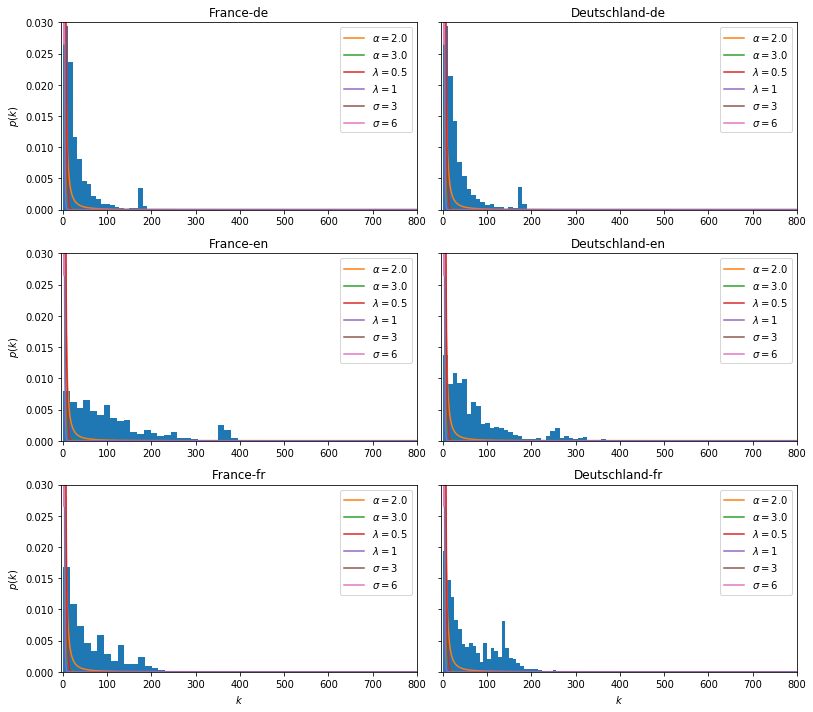

In [80]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=True)
X = np.linspace(1, 800, 1000)
PL_20 = power_law(X, 2)
PL_30 = power_law(X, 3)
E_05 = expo(X, 0.5)
E_1 = expo(X, 1)
LN_3 = lognormal(X, 1, 3)
LN_6 = lognormal(X, 1, 6)
j = 0
for basekey in Networks.keys(): 
    i = 0
    for key, item in sorted(Networks[basekey].items()):
        p = np.array(list(dict(item.degree()).values()))
        ax[i][j].hist(p, bins=50, density=True)    
        ax[i][j].plot(X, PL_20, label=r"$\alpha = 2.0$")
        ax[i][j].plot(X, PL_30, label=r"$\alpha = 3.0$")
        ax[i][j].plot(X, E_05, label=r"$\lambda = 0.5$")
        ax[i][j].plot(X, E_1, label=r"$\lambda = 1$")
        ax[i][j].plot(X, LN_3, label=r"$\sigma = 3$")
        ax[i][j].plot(X, LN_6, label=r"$\sigma = 6$")
        ax[i][j].set_title(basekey + "-" + key)
        ax[i][j].set_xlim(-5, 800)
       # ax[i][j].set_xscale('log')
        ax[i][j].set_ylim(0, 0.03)
       # ax[i][j].set_yscale('log')
        ax[i][j].legend(loc="best")
        i += 1
    j += 1

ax[0][0].set_ylabel(r"$p(k)$")
ax[1][0].set_ylabel(r"$p(k)$")
ax[2][0].set_ylabel(r"$p(k)$")
ax[2][0].set_xlabel(r"$k$")
ax[2][1].set_xlabel(r"$k$")
    
fig.set_size_inches(1.9 * fig.get_size_inches()[0], 2.5 * fig.get_size_inches()[1])
fig.tight_layout()

We find that our degree distribution is not *visually* well fitted by a power-law,
a log-normal distribution nor an exponential distribution.

#### 3.2.2 Average Clustering Coefficient

In [81]:
%%time
AvgClustering = {}
for basekey in UNetworks.keys(): 
    AvgClustering[basekey] = {}
    for key, graph in sorted(UNetworks[basekey].items()):
        print("Computing average clustering coefficient for {}-{} ...".format(basekey, key))
        t0 = time.time()
        AvgClustering[basekey][key] = nx.average_clustering(graph)
        t1 = time.time()
        print("Took {} seconds to compute the average shortest distance for {}-{}".format((t1-t0), basekey, key))

Computing average shortest distance for France-de ...
Took 0.5787243843078613 seconds to compute the average shortest distance for France-de
Computing average shortest distance for France-en ...
Took 2.2081024646759033 seconds to compute the average shortest distance for France-en
Computing average shortest distance for France-fr ...
Took 0.8290426731109619 seconds to compute the average shortest distance for France-fr
Computing average shortest distance for Deutschland-de ...
Took 0.5428013801574707 seconds to compute the average shortest distance for Deutschland-de
Computing average shortest distance for Deutschland-en ...
Took 0.7689366340637207 seconds to compute the average shortest distance for Deutschland-en
Computing average shortest distance for Deutschland-fr ...
Took 0.6781480312347412 seconds to compute the average shortest distance for Deutschland-fr
CPU times: user 5.6 s, sys: 8.05 ms, total: 5.61 s
Wall time: 5.61 s


In [83]:
AvgClustering

{'France': {'de': 0.41100395965359565,
  'en': 0.6381970155721018,
  'fr': 0.5643642693695381},
 'Deutschland': {'de': 0.41576283801247105,
  'en': 0.6089741395962236,
  'fr': 0.5833635929392722}}

We find that the average clustering coefficient is around 0.5.

#### 3.2.3 Average Shortest Path

In [69]:
%%time
AvgDistance = {}
for basekey in UNetworks.keys(): 
    AvgDistance[basekey] = {}
    for key, graph in sorted(UNetworks[basekey].items()):
        print("Computing average shortest path for {}-{} ...".format(basekey, key))
        t0 = time.time()
        AvgDistance[basekey][key] = nx.average_shortest_path_length(graph)
        t1 = time.time()
        print("Took {} seconds to compute the average shortest distance for {}-{}".format((t1-t0), basekey, key))

Computing average shortest distance for France-de ...
Took 55.009695291519165 seconds to compute the average shortest distance for France-de
Computing average shortest distance for France-en ...
Took 115.33113050460815 seconds to compute the average shortest distance for France-en
Computing average shortest distance for France-fr ...
Took 54.67338252067566 seconds to compute the average shortest distance for France-fr
Computing average shortest distance for Deutschland-de ...
Took 48.76618528366089 seconds to compute the average shortest distance for Deutschland-de
Computing average shortest distance for Deutschland-en ...
Took 30.99101495742798 seconds to compute the average shortest distance for Deutschland-en
Computing average shortest distance for Deutschland-fr ...
Took 42.34003567695618 seconds to compute the average shortest distance for Deutschland-fr
CPU times: user 5min 46s, sys: 720 ms, total: 5min 47s
Wall time: 5min 47s


In [85]:
AvgDistance

{'France': {'de': 2.793950092800471,
  'en': 2.699483905897566,
  'fr': 2.682011696718771},
 'Deutschland': {'de': 2.7572494911975594,
  'en': 2.645057945773936,
  'fr': 2.82206069122058}}

We find that the average shortest path is around 2.7.

### 3.3. Centralities

#### 3.3.1. Betweenness

In [126]:
%%time
Betweenness = {}
for basekey in UNetworks.keys(): 
    Betweenness[basekey] = {}
    for key, graph in UNetworks[basekey].items():
        print("Computing centrality for {}-{} ...".format(basekey, key))
        t0 = time.time()
        Betweenness[basekey][key] = nx.betweenness_centrality(graph)
        t1 = time.time()
        print("Took {} seconds to compute centrality for {}-{}".format((t1-t0), basekey, key))

Computing centrality for France-de ...
Took 51.21200895309448 seconds to compute the average shortest distance for France-de
Computing centrality for France-fr ...
Took 42.472615242004395 seconds to compute the average shortest distance for France-fr
Computing centrality for France-en ...
Took 83.3720052242279 seconds to compute the average shortest distance for France-en
Computing centrality for Deutschland-fr ...
Took 32.654135942459106 seconds to compute the average shortest distance for Deutschland-fr
Computing centrality for Deutschland-en ...
Took 22.612266302108765 seconds to compute the average shortest distance for Deutschland-en
Computing centrality for Deutschland-de ...
Took 47.94204330444336 seconds to compute the average shortest distance for Deutschland-de
CPU times: user 4min 40s, sys: 149 ms, total: 4min 40s
Wall time: 4min 40s


In [138]:
Betweenness

{'France': {'de': {'Frankreich': 0.07961440814306334,
   'ANDRA': 9.953761284612604e-06,
   'Abbrand (Kerntechnik)': 0.00022810582371027654,
   'Atomausstieg': 0.023065430127722678,
   'Atommacht': 0.004600136933847221,
   'Atomstreitkraft': 0.0020923389945972874,
   'Biomasse': 0.00517131243954388,
   'Bure (Felslabor)': 2.6242273933362973e-05,
   'Cadarache': 0.0001985711771030239,
   'Cogema': 0.00023748528390230806,
   'EU-Emissionshandel': 0.006813564406652314,
   'Elektrogebäudeheizung': 0.001908985108404739,
   'Energiewende': 0.053808887349448456,
   'Energiewende nach Staaten': 0.019113268334746785,
   'Engie': 0.0023199959476854154,
   'Erdgas': 0.040036593718788094,
   'Erdöl': 0.019960416315478575,
   'Erneuerbare Energien': 0.04822055617525431,
   'Europäische Gemeinschaft für Kohle und Stahl': 4.06739044726622e-05,
   'Force de frappe': 0.0011460594365050039,
   'Generation IV International Forum': 0.0010391500477733733,
   'Geschichte der Ölförderung Frankreichs': 0.0003

#### 3.3.2. Eigenvector

In [127]:
%%time
Eigenvector = {}
for basekey in UNetworks.keys(): 
    Eigenvector[basekey] = {}
    for key, graph in sorted(UNetworks[basekey].items()):
        print("Computing centrality for {}-{} ...".format(basekey, key))
        t0 = time.time()
        Eigenvector[basekey][key] = nx.eigenvector_centrality(graph)
        t1 = time.time()
        print("Took {} seconds to compute centrality for {}-{}".format((t1-t0), basekey, key))

Computing centrality for France-de ...
Took 0.4598500728607178 seconds to compute centrality for France-de
Computing centrality for France-en ...
Took 0.837620735168457 seconds to compute centrality for France-en
Computing centrality for France-fr ...
Took 1.1414625644683838 seconds to compute centrality for France-fr
Computing centrality for Deutschland-de ...
Took 0.42000651359558105 seconds to compute centrality for Deutschland-de
Computing centrality for Deutschland-en ...
Took 0.2090163230895996 seconds to compute centrality for Deutschland-en
Computing centrality for Deutschland-fr ...
Took 0.5422847270965576 seconds to compute centrality for Deutschland-fr
CPU times: user 3.61 s, sys: 7.93 ms, total: 3.62 s
Wall time: 3.61 s


In [137]:
Eigenvector

{'France': {'de': {'Frankreich': 0.009280644106816855,
   'ANDRA': 0.0002647914712044401,
   'Abbrand (Kerntechnik)': 0.0032504638779167648,
   'Atomausstieg': 0.012295164271585939,
   'Atommacht': 0.0013684972610450291,
   'Atomstreitkraft': 0.0003243766212548404,
   'Biomasse': 0.0020473514901323785,
   'Bure (Felslabor)': 0.0008090321864525563,
   'Cadarache': 0.0015916180994668236,
   'Cogema': 0.0009633759869231081,
   'EU-Emissionshandel': 0.001080900074752114,
   'Elektrogebäudeheizung': 0.0006188628456818117,
   'Energiewende': 0.009892611365343746,
   'Energiewende nach Staaten': 0.006776515028730748,
   'Engie': 0.0011459734664994745,
   'Erdgas': 0.004199516049554599,
   'Erdöl': 0.002744602954170468,
   'Erneuerbare Energien': 0.011161030038068122,
   'Europäische Gemeinschaft für Kohle und Stahl': 0.00018154585031956874,
   'Force de frappe': 0.0005260512404531596,
   'Generation IV International Forum': 0.0023339916328502406,
   'Geschichte der Ölförderung Frankreichs': 0

#### 3.3.3. Clustering Coefficient

In [128]:
%%time
Clustering = {}
for basekey in UNetworks.keys(): 
    Clustering[basekey] = {}
    for key, graph in UNetworks[basekey].items():
        print("Computing centrality for {}-{} ...".format(basekey, key))
        t0 = time.time()
        Clustering[basekey][key] = nx.clustering(graph)
        t1 = time.time()
        print("Took {} seconds to compute centrality for {}-{}".format((t1-t0), basekey, key))

Computing centrality for France-de ...
Took 0.6602003574371338 seconds to compute centrality for France-de
Computing centrality for France-fr ...
Took 0.9128141403198242 seconds to compute centrality for France-fr
Computing centrality for France-en ...
Took 2.418410062789917 seconds to compute centrality for France-en
Computing centrality for Deutschland-fr ...
Took 0.7435507774353027 seconds to compute centrality for Deutschland-fr
Computing centrality for Deutschland-en ...
Took 0.8750975131988525 seconds to compute centrality for Deutschland-en
Computing centrality for Deutschland-de ...
Took 0.6238598823547363 seconds to compute centrality for Deutschland-de
CPU times: user 6.22 s, sys: 12 ms, total: 6.24 s
Wall time: 6.24 s


In [136]:
Clustering

{'France': {'de': {'Frankreich': 0.057714070162202945,
   'ANDRA': 0.5238095238095238,
   'Abbrand (Kerntechnik)': 0.29523809523809524,
   'Atomausstieg': 0.09649912928601453,
   'Atommacht': 0.13053613053613053,
   'Atomstreitkraft': 0.21082621082621084,
   'Biomasse': 0.1385858585858586,
   'Bure (Felslabor)': 0.5111111111111111,
   'Cadarache': 0.26877470355731226,
   'Cogema': 0.24,
   'EU-Emissionshandel': 0.12755102040816327,
   'Elektrogebäudeheizung': 0.21904761904761905,
   'Energiewende': 0.07135790254761316,
   'Energiewende nach Staaten': 0.09172932330827067,
   'Engie': 0.10685249709639953,
   'Erdgas': 0.06773218401125378,
   'Erdöl': 0.09545195323638438,
   'Erneuerbare Energien': 0.07239912872108703,
   'Europäische Gemeinschaft für Kohle und Stahl': 0.2,
   'Force de frappe': 0.25263157894736843,
   'Generation IV International Forum': 0.14814814814814814,
   'Geschichte der Ölförderung Frankreichs': 0.4,
   'Glaskokille': 0.38562091503267976,
   'Grand-Maison': 0.6666

#### 3.3.4 PageRank

In [129]:
%%time
PageRank = {}
for basekey in UNetworks.keys(): 
    PageRank[basekey] = {}
    for key, graph in UNetworks[basekey].items():
        print("Computing centrality for {}-{} ...".format(basekey, key))
        t0 = time.time()
        PageRank[basekey][key] = nx.pagerank(graph)
        t1 = time.time()
        print("Took {} seconds to compute centrality for {}-{}".format((t1-t0), basekey, key))

Computing centrality for France-de ...
Took 1.521245002746582 seconds to compute centrality for France-de
Computing centrality for France-fr ...
Took 2.1050539016723633 seconds to compute centrality for France-fr
Computing centrality for France-en ...
Took 4.2112298011779785 seconds to compute centrality for France-en
Computing centrality for Deutschland-fr ...
Took 1.9692776203155518 seconds to compute centrality for Deutschland-fr
Computing centrality for Deutschland-en ...
Took 2.3395447731018066 seconds to compute centrality for Deutschland-en
Computing centrality for Deutschland-de ...
Took 1.5042529106140137 seconds to compute centrality for Deutschland-de
CPU times: user 13.5 s, sys: 116 ms, total: 13.7 s
Wall time: 13.7 s


In [135]:
PageRank

{'France': {'de': {'Frankreich': 0.0043752407433078665,
   'ANDRA': 0.00019233040021669396,
   'Abbrand (Kerntechnik)': 0.0003901264068891072,
   'Atomausstieg': 0.0030115617358944797,
   'Atommacht': 0.0015562852559510756,
   'Atomstreitkraft': 0.0007390812976463456,
   'Biomasse': 0.001644609045694151,
   'Bure (Felslabor)': 0.00023169845363968925,
   'Cadarache': 0.00041385013105289554,
   'Cogema': 0.0004975017336774383,
   'EU-Emissionshandel': 0.0011217359691040865,
   'Elektrogebäudeheizung': 0.0005002811975472802,
   'Energiewende': 0.005198608802306635,
   'Energiewende nach Staaten': 0.003074861803231887,
   'Engie': 0.000803809985152224,
   'Erdgas': 0.004589547583492881,
   'Erdöl': 0.0030148047940251306,
   'Erneuerbare Energien': 0.005259900964957856,
   'Europäische Gemeinschaft für Kohle und Stahl': 0.00019547911418851872,
   'Force de frappe': 0.0005190835408864604,
   'Generation IV International Forum': 0.0005187698901118115,
   'Geschichte der Ölförderung Frankreich

#### 3.3.5 Characterising nodes by their centralities

In [170]:
filename_base = "{}/Nx-{}-{}-final.{}"
# Adding a centrality property to the nodes of our graph
for basekey in UNetworks.keys(): 
    for key, graph in UNetworks[basekey].items():
        for node in graph.nodes():
            graph.nodes[node]["Mbetweenness"] = float(Betweenness[basekey][key][node])
            graph.nodes[node]["Meigenvector"] = float(Eigenvector[basekey][key][node])
            graph.nodes[node]["Mclusteringcoeff"] = float(Clustering[basekey][key][node])
            graph.nodes[node]["Mpagerank"] = float(PageRank[basekey][key][node])
        # Saving the graphs to open them with gephi
        nx.write_gml(UNetworks[basekey][key], filename_base.format(cwd, basekey, key, "gml"))

### 3.4 Communities

Communities are computed with gephi 
[*Bastian M., Heymann S., Jacomy M. (2009).
 Gephi: an open source software for exploring and manipulating networks. 
 International AAAI Conference on Weblogs and Social Media*]
 using modularity.
 Graph images are obtained as following :
 * The coloring corresponds to a community,
 * The node size is proportional to it's eigenvector centrality score,
 * The layout is obtained using ForceAtlas2 (Jacomy M, Venturini T, Heymann S, Bastian M (2014) ForceAtlas2, a Continuous Graph Layout Algorithm for Handy Network Visualization Designed for the Gephi Software. PLoS ONE 9(6): e98679. https://doi.org/10.1371/journal.pone.0098679)
 
 The communities topics are obtained by browsing about the communities and checking the node labels.

***France-fr***

The network contains 9 classes : 

* The blue one is about french politicians and rivers,
* The orange one is about the civil nuclear industry (powerplants, etc.)
* The green one is about war and nuclear weapons,
* The cyan one is about reknown physicists (Feynman, Planck, etc.),
* The brown one is about bikes,
* The black one is about chemical elements,
* The purple one is related to gas, combustion and renewable energy,
* The grey one is related to combustion and fire,
* the pink one is related about train and trainlines.

The big blue node is the node we start our exploration from.

[France-fr](./france-fr.png)

***France-en***

The network contains 11 classes : 
* The black one is about oil/gas industry,
* The orange one is about renewable energy, climate change, nuclear power, fossil fuels, etc.
* The purple one is about combustion engines and cars,
* The pink one is about missiles (weapons),
* The cyan one is about scientific installations to study nuclear physics (e.g. Large Hadron Collider, etc.) and
    reknown scientists in the field,
* The blue one is about war aircrafts,
* The green one is about geopolitics and nuclear weapons,
* The brown one is about renewable energy by countries.
* There are three distinct grey classes that deal with nuclear power plants, train-like transportation,
    and fuel and fire respectively.
   
The big dark node in the middle of the coloured ones corresponds to the 1973 oil crisis and not to the node "France",
which is colored in blue in this case.

[France-en](./france-en.png)

***France-de***

The  network contains 7 classes : 
* The cyan one is about nuclear powerplants in the US with a big node corresponding to General Electrics (company),
* The green one corresponds to civil nuclear energy,
* The pink one corresponds to topics closely related to France and in particular french industry (Renault, etc.),
* The purple one corresponds to renewables, oil and gas,
* The blue one corrresponds to wind, water energy and turbines,
* The black one regroups nuclear weapons,
* The orange one deals with the energy network, the energy economy and industrial groups (e.g. RWE, E.ON, etc.)

[France-de](./france-de.png)

***Deutschland-fr***

The network contains 9 classes : 
* The pink one corresponds to electricity, smart-grids, windmills and "hydromills",
* The cyan one corresponds to windmill energy in various countries,
* The purple one is very hetrogeneous and regroups everything closely related to Germany (rivers, bombings,
    political organizations, etc.),
* The blue one corresponds to coal, oil, solar, nuclear, etc. energies,
* The brown one corresponds to coal mining sites in France and its surroundings,
* The black one corresponds to reknown nuclear physicists,
* The green one corresponds to chemical elements,
* The grey one corresponds to Russia and Donbass-related topics,

[Deutschland-fr](./deutschland-fr.png)

***Deutschland-en***

The network contains 7 classes : 

* The green one corresponds to Cold War, Communism, World War II and contains the 1973 oil crisis too,
* The grey one is about reknown physicists,
* The purple one is about the different types of power (nuclear, coal, hydroelectricity, etc.) and is very heterogeneous,
* The blue one is about cars and car brands in Germany (VW, Mercedes, etc.),
* The orange one is about cars and car brands in the United States,
* The cyan one is about formula one and other car races/circuits,
* The pink one is about BMW motorcycles.

[Deutschland-en](./deutschland-en.png)

***Deutschland-de***
The network contains 7 classes : 
* The orange one is about nuclear power plants in Germany,
* The blue one is about nuclear energy,
* The cyan one is about nuclear power plants in the United States,
* The pink one is about nuclear weapons,
* The green one is about natural gas and oil,
* The purple one is about renewables,
* the black one is about xar brands.

The big blue node is the node we start our exploration from.

[Deutschland-en](./deutschland-en.png)

## 4. Discussion

### 4.1. On the basic properties of our networks

The obtained degree distributions do look like power-laws in particular for the networks 
*France-de* and *Deutschland-de*.
We would like to discuss two points. 
The first one is that our degree distributions do not fit "under" the $\alpha = 2$ power-law distribution. This is
a hint that the networks we built are *biased* because of the limit in explored nodes we set in our
exploration algorithm. Because our starting point is a node with very high degree (in the order of a thousand)
we probably didn't sample enough nodes of small degree.
The second point to discuss is the presence of a spike in the degree distribution more or less further along the
tail (around $k = 200$ for *Deutschland-de*). We think this is also a lack of sampling lesser degree nodes, which
gives us this very heavy tail. 

The average distance in our networks is less than 3, which is quite small.
One way to see it would be to say that this is expected from the way we build our network.
We see that the maximum layer we reached is 3, because of our limit on the amount of explored nodes.
On the other hand we could observe that because we built our network using some sort of BFS that reached a 
maximum depth of 3, the maximum distance to expect between two nodes is 6. 
The fact that the average distance falls far from this value is a hint that the nodes are still well connected between each other (the friends of my friends are my friends), like in a real network.
This feature explains why doing a *pseudo-BFS* like we did reaches a lot of nodes within a relative short
depth (e.g. 2 or 3) of exploration.

The clustering coefficient we obtain is on the order of 0.5 for all our networks. This is quite large and
coherent with the fact that we are studying a real network. 

### 4.2. Communities obtained

We first see that the number of communities recovered is in the first order the same for all networks.
If we compare now rigorously the amount of communities detected we observe that the more edges the network has
and the more communities are detected. This phenomena seems hard to interpret.

It is interesting to note that in general we obtain semantically meaningful communities, and that only in a few cases (like *Deutschland-fr* purple) we obtain very heterogeneous communities. The way we label communities could
be improved, via a natural language processing algorithm for example. This would allo us to name the communities
in a more meaningful and compact way directly on the graph and avoid annoying thorough descriptions.

Let's compare the different results obtained when starting from different entries, 
in french language  (*France-fr* v/s *Deutschland-fr*).
We see no clear difference in the topics mentioned when starting from the two entries.
Both networks have 9 communities based on modularity. The topics are relatively the same : nuclear weapons,
types of power production (nuclear, fossil, renewable), reknown physicists, chemical elements. There are some
discrepancies : when starting from France we obtain a community dealing with trains and another with bikes, whereas when starting from Germany we obtain a community that is more windmill-oriented and another one oriented
towards coal-mining.
It could be tempting to draw parallels between the reality of germany's energy mix and the fact that we get these last two communities starting from Germany but not from France. However this would not be very rigorous. In the
same way, we couldn't really interpret why we get a community about bikes starting from France that we do not get starting from Germany.

Let's compare now the differences observed when switchin languages of exploration, in the case of the starting entry Germany (*Deutschland-de*, *Deutschland-fr*, *Deutschland-en*).
If we assume that most articles in a languages are written from natives of the region where the language is 
spoken, we expect that a bias will be present in the network we build. This can be observed in the strong emphasis 
that is put on cars and related in the *Deutschland-en* comparing it to the *Deutschland-fr* one for example.

### 4.3. General Remarks

The networks we built are very rich in informations. It is obviously hard to extract them "by hand" or to draw any quantitative and rigorous conclusions from them. However it allows us to get a feel of the cultural bias present in wikipedia and a good idea of subjects at the intersection between a country and a topic.

There are some improvements we could bring to this whole process :
* Use natural language processing to detect what communities/nodes are about in a more rigorous way,
* In the same way, this tool could allow us to remove meaningless wikipedia pages like "list of power plants in the World ranked by energy output" (dummy example) that tend to make the data noisy,
* Restrain a bit the topic of exploration : the concept of energy is actually quite large and it brings and brings together topics that do not have much to do with one another.

Had we had some more time, we could have ranked the nodes in every network by their different centralities and check if any meaningful conclusion could be drawn from that.

It would have been good to be able to restrict the exploration of Wikipedia's network by the depth of the "pseudo-BFS" used rather than the number of nodes processed. Indeed, this would allow for more robust interpretations of 
the network structure. 